# Principal Component Analysis
- By Yuan-Sen Ting, March 2025, for Astron 5550

In the expanding universe of data analysis, we often encounter high-dimensional datasets that challenge our ability to extract meaningful patterns. Astronomical images, such as those of distant galaxies, can contain thousands or even millions of pixels, each representing a dimension in our data space. How can we efficiently analyze such complex data and identify the underlying structures that truly matter?

Principal Component Analysis (PCA) offers a solution to this challenge by reducing dimensionality while preserving essential information. When applied to astronomical data, PCA can help us identify the primary features that characterize different galaxy morphologies, separate signal from noise, and compress data without losing critical scientific information.

In this tutorial, we'll first have some fun applying PCA to Pokémon sprite images. Then, we'll turn to a more astronomical application, using PCA to analyze galaxy images from modern surveys. 

## Learning Objectives

By working through this tutorial, you'll gain a practical understanding of PCA. By the end, you will be able to:

- Understand the mathematical foundations of PCA and its relationship to eigendecomposition
- Implement PCA from scratch using singular value decomposition (SVD)
- Apply PCA to reduce the dimensionality of image data while preserving key information
- Visualize and interpret principal components in image contexts
- Quantify the information captured by different numbers of principal components
- Reconstruct images from their principal components and evaluate reconstruction quality

## Prerequisites
 
This tutorial assumes familiarity with:
- Basic linear algebra concepts (matrices, eigenvectors)
- The theoretical foundations of PCA as discussed in the lecture, including:
   - Covariance matrices and their eigendecomposition
   - Singular Value Decomposition (SVD) and its relationship to PCA
   - Variance maximization and dimensionality reduction principles
 
No prior knowledge of Pokémon or galaxy morphology is required - just bring your curiosity!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

# Set plotting parameters for better visualization
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = (8, 6)

# For reproducibility
np.random.seed(42)

## Understanding the Data: Pokémon Sprites

Before diving into PCA, let's familiarize ourselves with our first dataset. We'll begin with a collection of Pokémon sprite images.

- **Each row** in our dataset represents a single grayscale Pokémon sprite image.
- **Each image** is 64×64 pixels, resulting in 4,096 dimensions per image.
- **Pixel values** range from 0 (white) to 1 (black).

This type of high-dimensional image data is perfect for demonstrating PCA, as it contains both structured patterns and redundant information.

In [2]:
# Load the Pokémon dataset
data = np.load('dataset_images_pokemon.npz')
images = data['images']

# Check the shape of the loaded data
print("Shape of the loaded images:", images.shape)
print(f"Number of images: {images.shape[0]}")
print(f"Dimensions per image: {images.shape[1]}")

Shape of the loaded images: (1168, 4096)
Number of images: 1168
Dimensions per image: 4096


Before applying any dimensionality reduction, it's important to understand what our raw data looks like. Let's visualize some of the Pokémon sprites from our dataset to get a sense of what we're working with.

The function below will help us display multiple images in a grid format, which we'll use throughout this tutorial to visualize both original images and their reconstructions.

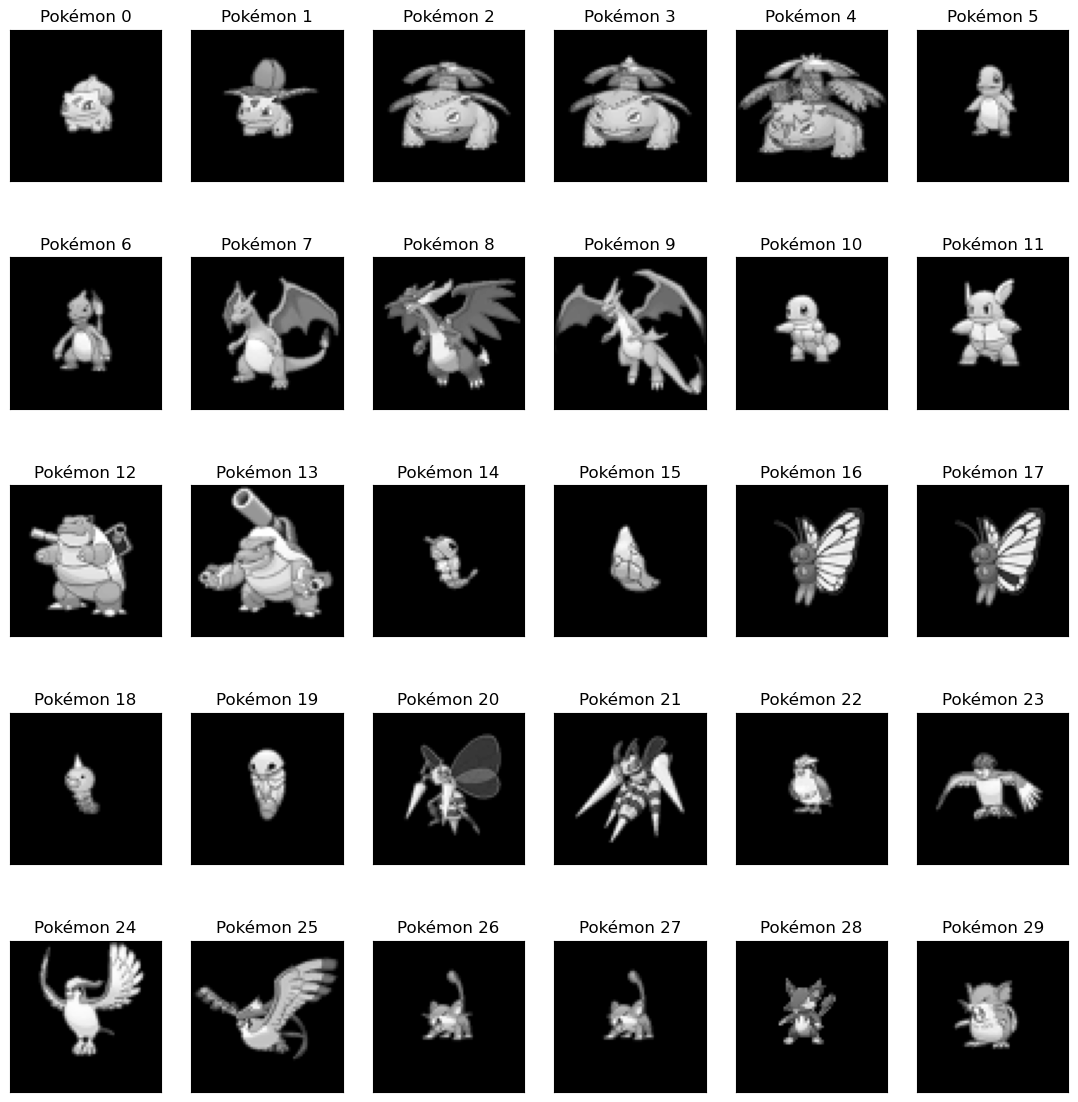

In [3]:
def plot_gallery(images, titles, h, w, n_row=2, n_col=6):
    """
    Plot a gallery of images.
    
    Parameters:
    -----------
    images : numpy.ndarray
        Each row is a flattened image.
    titles : list
        Titles for each subplot.
    h : int
        Image height in pixels.
    w : int
        Image width in pixels.
    n_row : int
        Number of rows in the gallery.
    n_col : int
        Number of columns in the gallery.
    """
    # Assert to make sure we have enough images and titles for the grid
    assert len(images) >= n_row * n_col
    assert len(titles) >= n_row * n_col
    
    # Initialize the plot
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    # Loop to populate the gallery
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        
        # Reshape the flattened image data to 2D and plot it
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        
        # Add title and remove axis ticks
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
    plt.show()

# Display a sample of Pokémon sprites
plot_gallery(images, [f"Pokémon {i}" for i in range(30)], 64, 64, 5, 6)

## The Mathematical Foundation of PCA
 
Principal Component Analysis is a mathematical technique that transforms our data into a new coordinate system where the axes (called principal components) are ordered by the amount of variance they capture. Let's break down the key steps:
 
#### Step 1: Centering the Data
 
We start by computing the mean of our dataset and subtracting it from each data point. If we have $N$ data points $\{\mathbf{x}_n\}_{n=1}^N$, each being a row vector in $\mathbb{R}^D$, the mean vector $\bar{\mathbf{x}}$ is:
 
$$
\bar{\mathbf{x}} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_n
$$
 
Centering the data ensures that the first principal component passes through the center of the data cloud:
$$
\mathbf{x}_n \leftarrow \mathbf{x}_n - \bar{\mathbf{x}}
$$
 
#### Step 2: Computing the Singular Value Decomposition (SVD)
 
Instead of directly computing the covariance matrix, we apply SVD to our centered data matrix $X \in \mathbb{R}^{N \times D}$:
  
$$
X = U\Sigma V^T
$$
 
where $U \in \mathbb{R}^{N \times N}$, $\Sigma \in \mathbb{R}^{N \times D}$ is a diagonal matrix of singular values, and $V \in \mathbb{R}^{D \times D}$. The columns of $U$ and $V$ are orthonormal vectors (i.e., $U^T U = I$, $V^T V = I$), meaning each column has unit length and is orthogonal to all other columns. These orthonormal properties are crucial for PCA as they ensure our principal components form an orthogonal basis.

#### Step 3: Relationship to Covariance Matrix

The covariance matrix $\mathbf{S}$ can be expressed in terms of the SVD components:
$$
\mathbf{S} = \frac{1}{N}\sum_{n=1}^N (\mathbf{x}_n^T \mathbf{x}_n) = \frac{1}{N} X^T X = \frac{1}{N} V \Sigma^T U^T U \Sigma V^T = \frac{1}{N} V \Sigma^2 V^T
$$

This shows that:
- The columns of $V$ are the eigenvectors of $X^T X$ (our principal components)
- The squared singular values $\sigma_i^2/N$ are the eigenvalues of $\mathbf{S}$ (the variance captured by each component), where $\sigma_i$ are the diagonal elements of $\Sigma$ (the singular values from SVD)
 
#### Step 4: Dimensionality Reduction
  
To reduce dimensions, we select the first $M$ columns of $V$ (the principal components that capture the most variance) and project our data onto this subspace:
  
$$
\mathbf{Z} = X \mathbf{V}_M = U_M \Sigma_M
$$
     
where $U_M$ consists of the first $M$ columns of $U$ and $\Sigma_M$ is the diagonal matrix containing the first $M$ singular values. [see the lecture notes for the derivation].
   


Now that we understand the theory, let's implement PCA using NumPy. We'll create two functions:
 
1. `pca()`: A main function that performs PCA on raw data and returns the projected data and principal components ($P=V_M^T$).
2. `svd2pca()`: A helper function that allows us to try different numbers of principal components without recomputing the SVD.
 
Both functions preserve the original components of SVD ($U$, $S$, $V^T$) to give us flexibility in our analysis.
 
Note that NumPy's `linalg.svd()` function returns $U$, $S$, and $V^T$ (the transpose of $V$), where $S$ is a 1D array containing the singular values (the diagonal elements of $\Sigma$). This means that the principal components are the first `n_pc` rows of $V^T$ (equivalent to the first `n_pc` columns of $V$ in our mathematical derivation). The singular values in $S$ represent the square roots of the eigenvalues of the covariance matrix (scaled by a factor of $\sqrt{N}$).

In [4]:
def pca(X, n_pc=2):
    """
    Perform Principal Component Analysis to reduce the dimensionality of the data.
    
    Parameters:
    -----------
    X : numpy.ndarray
        The original data. Each row is a data sample.
    n_pc : int
        Number of principal components to use.
    
    Returns:
    --------
    tuple
        (projected data, principal components, U, S, Vt)
    """
    # Copy the data to avoid modifying the original dataset
    X = X.copy()
    
    # Get the shape of the data matrix
    n_samples, n_features = X.shape
    
    # Step 1: Center the data by subtracting the mean of each feature
    M = np.mean(X, axis=0)
    X -= M
    
    # Step 2: Compute the Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(X)
    
    # Step 3: Get the first 'n_pc' principal components
    components = Vt[:n_pc] 
    
    # Step 4: Project the data onto 'n_pc' dimensions (calculating the projection coefficients)
    projected = U[:, :n_pc] * S[:n_pc]
    
    return projected, components, U, S, Vt


def svd2pca(U, S, Vt, n_pc=2):
    """
    Project onto a different number of principal components given a precomputed SVD.
    
    Parameters:
    -----------
    U, S, Vt : numpy.ndarray
        The SVD components.
    n_pc : int
        Number of principal components to use.
        
    Returns:
    --------
    tuple
        (projected data, principal components, singular values)
    """
    # Select the first 'n_pc' principal components
    components = Vt[:n_pc]
    
    # Project the data onto 'n_pc' dimensions
    projected = U[:, :n_pc] * S[:n_pc]
    
    return projected, components, S

## Discovering "Eigen-Pokémon": Visualizing Principal Components

When we apply PCA to image data like our Pokémon sprites, we can visualize the principal components themselves as images. These "Eigen-Pokémon" reveal the fundamental visual patterns that distinguish different Pokémon in our dataset. Each principal component represents a specific combination of pixels that tend to vary together across all sprites. By visualizing these components as images, we can see exactly what visual features contribute most to the variation in our dataset.

Let's compute and visualize the first 100 principal components:

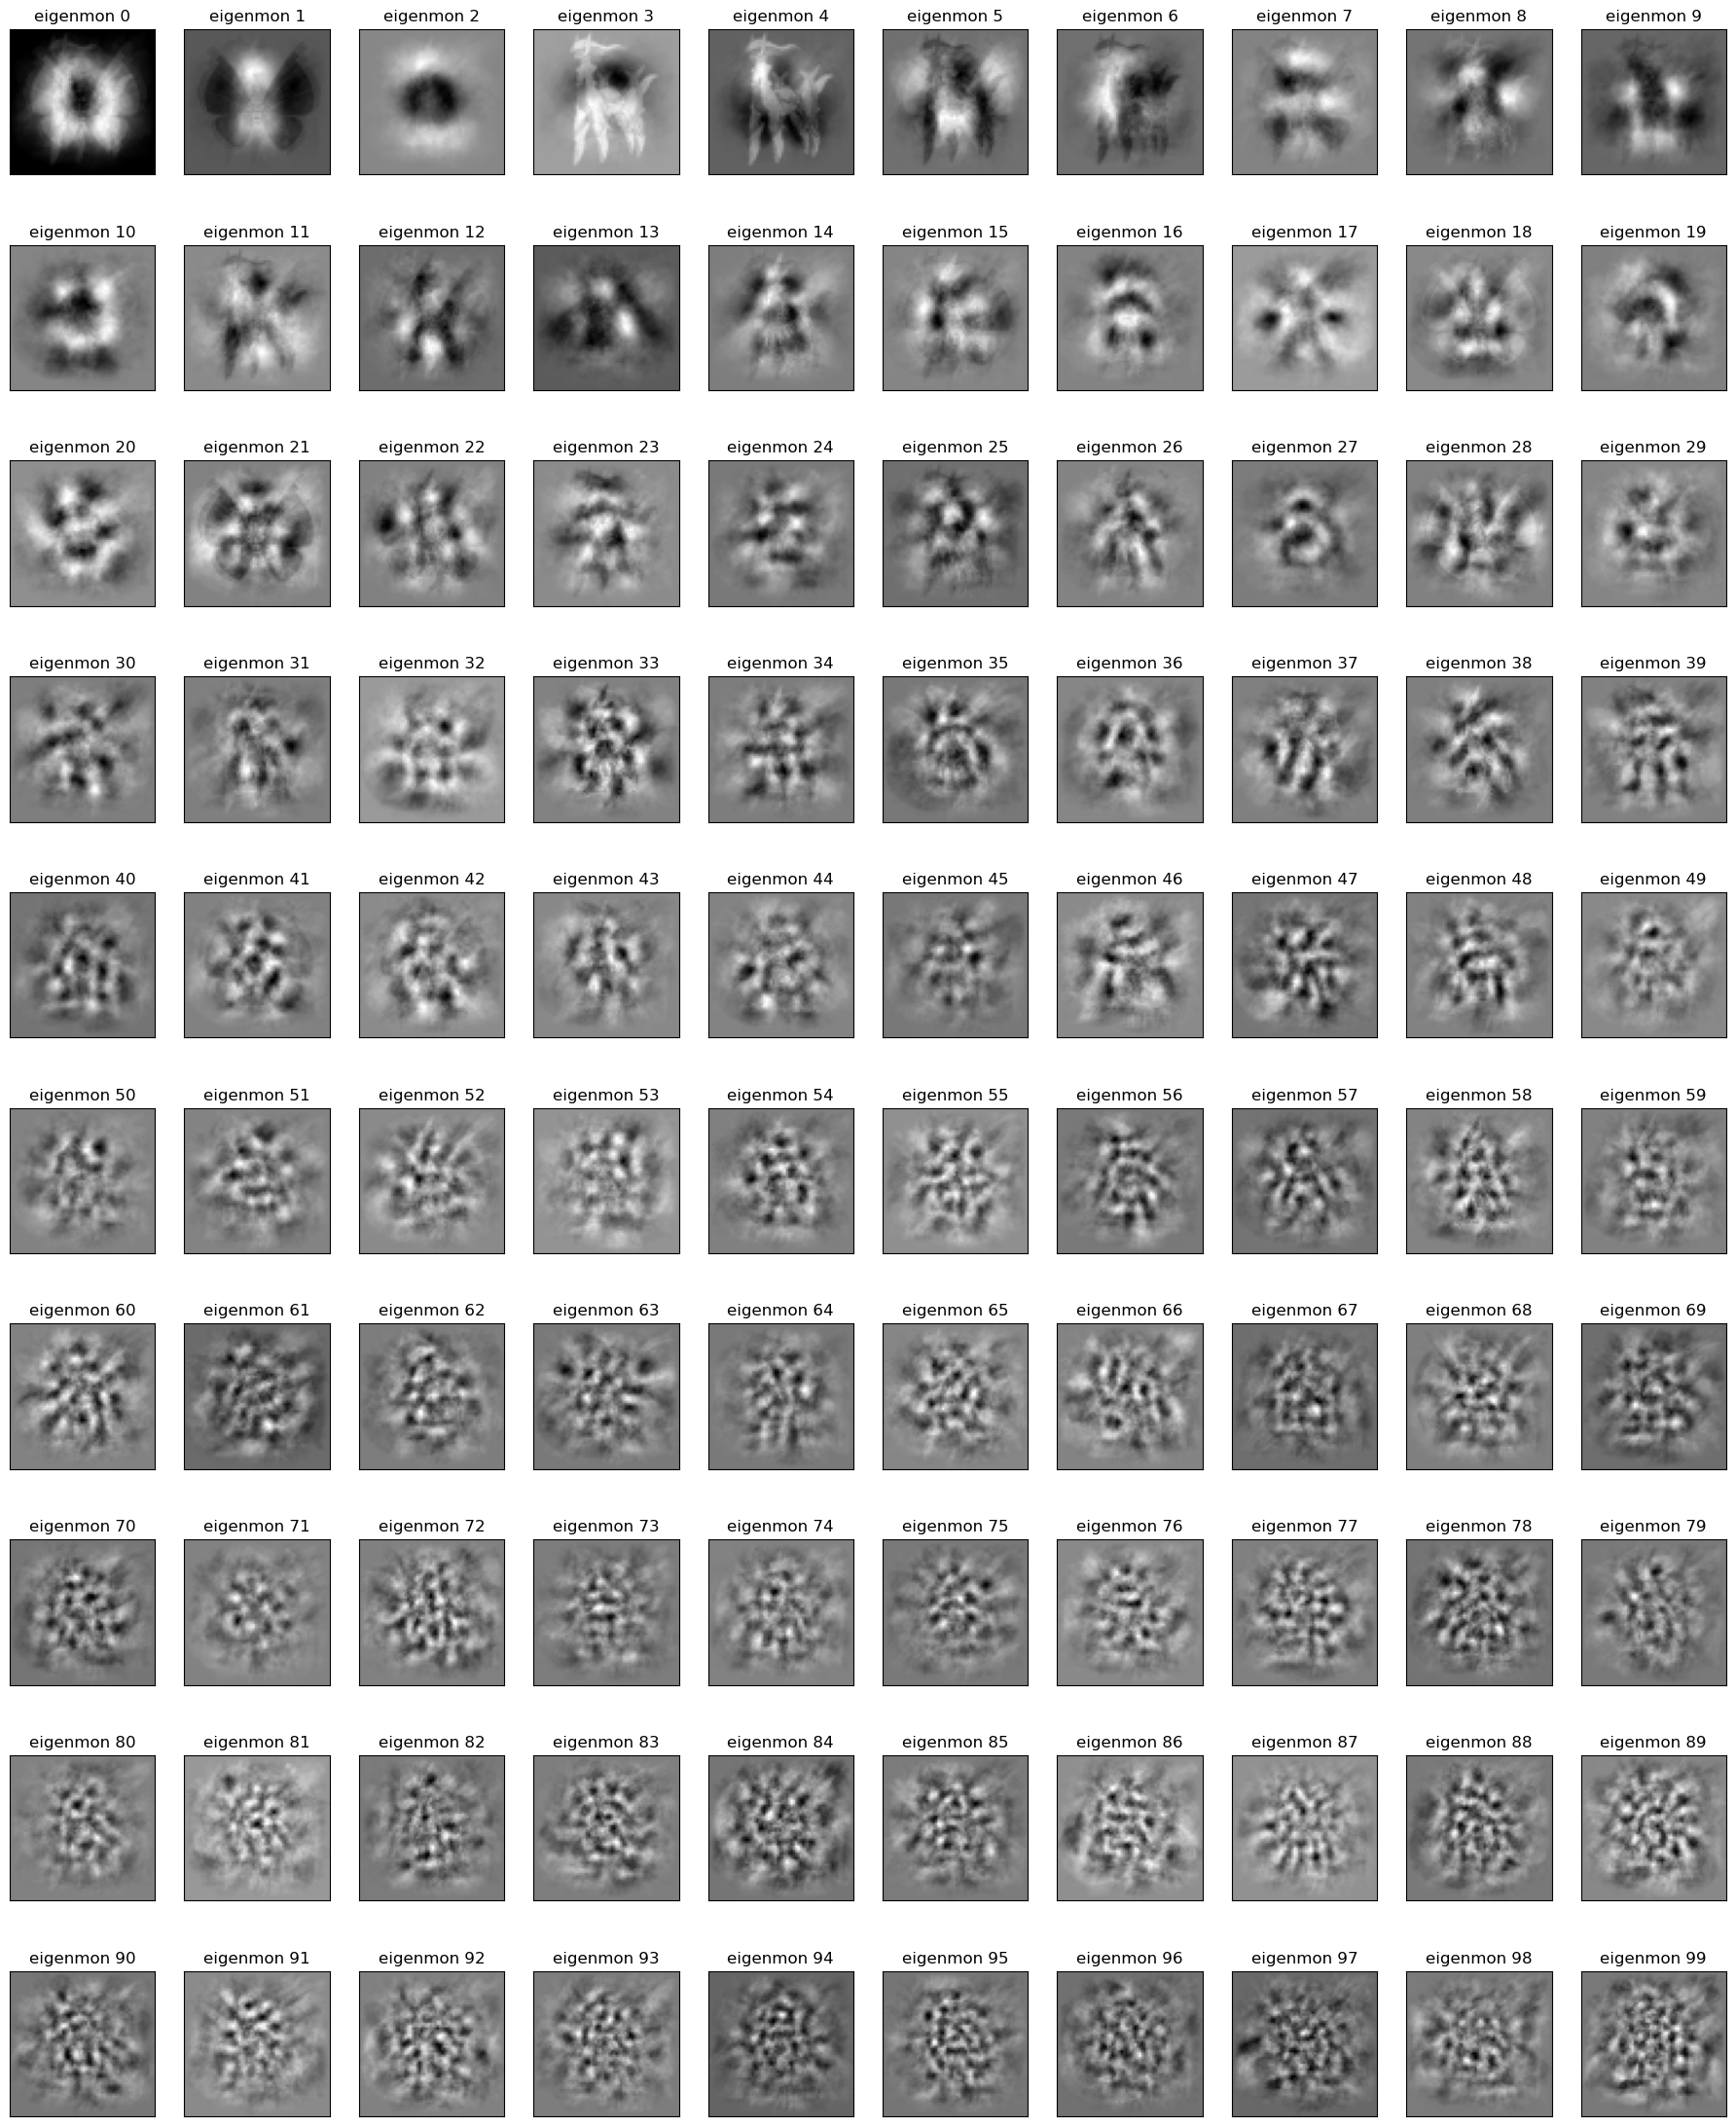

In [5]:
# Setting the parameters for PCA and the image shape
h = 64  # Height of images
w = 64  # Width of images
n_components = 100  # Number of principal components to extract

# Perform PCA
Z, P, U, S, Vt = pca(images, n_pc=n_components)

# Reshape the principal components to visualize them as images
eigenmon = P.reshape((n_components, h, w))

# Generate titles for the gallery
eigenmon_titles = [f"eigenmon {i}" for i in range(eigenmon.shape[0])]

# Visualize the first 100 principal components
plot_gallery(eigenmon, eigenmon_titles, h, w, n_components//10, 10)

Take a moment to examine these principal components:

1. **First component (eigenmon 0-8)**: This captures the most dominant pattern across all Pokémon sprites - often related to the overall silhouette and general Pokémon shape.

2. **Middle components (eigenmon 8-20)**: As we move further down, the components begin to capture more specific features and characteristic shapes.

3. **Later components (eigenmon 21+)**: These represent increasingly fine details, eventually reaching patterns that might be specific to just a few Pokémon.

Notice how the components become increasingly "noisy" as you move to higher numbers. This reflects the fact that later components capture less and less of the total variance in the dataset.
 


In the context of SVD, the eigenvalues $\lambda_i$ of the covariance matrix $X^TX$ are related to the singular values by:
  
$$\lambda_i = \frac{\sigma_i^2}{N}$$
  
where $N$ is the number of samples. The proportion of total variance explained by the $i$-th component is:
  
$$\text{variance explained}_i = \frac{\lambda_i}{\sum_j \lambda_j}$$
  
The cumulative variance explained by the first $k$ components is the sum of their individual contributions:

$$\text{cumulative variance explained}_k = \sum_{i=1}^{k} \frac{\lambda_i}{\sum_j \lambda_j}$$

This cumulative sum helps us determine how many components we need to retain to preserve a desired percentage of the total variance in our data. As we add more components, the cumulative explained variance approaches 100%.

Next, let's quantify exactly how much variance each component explains, which will help us decide how many components to keep for our dimensionality reduction.

In [ ]:
# Calculate eigenvalues from singular values
eigenvalues = (S**2) / images.shape[0]  # Convert singular values to eigenvalues
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(cumulative_variance)), cumulative_variance * 100, color='#4287f5', linewidth=2.5)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance (%)', fontsize=14)
plt.title('Cumulative Variance Explained', fontsize=16)
plt.grid(True, alpha=0.3)
plt.axhline(y=90, color='#e83e8c', linestyle='--', linewidth=2, label='90% Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

# Print the number of components needed for 90% explained variance
n_components_90 = np.where(cumulative_variance >= 0.9)[0][0] + 1
print(f"Number of components needed to explain 90% of variance: {n_components_90}")
print(f"This represents {n_components_90/len(eigenvalues):.2%} of the original dimensions")

## Reconstructing Pokémon Using Principal Components
 
One of the most powerful aspects of PCA is that it allows us to reconstruct our original data from the reduced-dimensional representation. This gives us a concrete way to visualize what information is preserved and what is lost during dimensionality reduction.
 
The reconstruction process follows directly from the PCA decomposition. If we denote our original data matrix as $X \in \mathbb{R}^{N \times D}$ (with $n$ samples and $d$ dimensions), the mean-centered data as $\widetilde{X} = X - \mu$ (where $\mu$ is the mean vector), and the matrix of principal components as $V_M \in \mathbb{R}^{D \times M}$ (where $M$ is the number of components we retain), then:
  
1. The projection (the coefficients) onto the principal component space is given by: $Z = U_M \Sigma_M \in \mathbb{R}^{N \times M}$
2. The reconstruction back to the original space (including also the basis) is: $\widehat{X} = ZV_M^T + \mu = (U_M \Sigma_M)V_M^T + \mu \in \mathbb{R}^{N \times D}$
  

The reconstruction error decreases monotonically as we include more principal components, with the full reconstruction ($M = D$) yielding $\widehat{X} = X$ when using all components.
  
Let's compare reconstructions using different numbers of principal components to visualize this trade-off between dimensionality reduction and reconstruction fidelity.

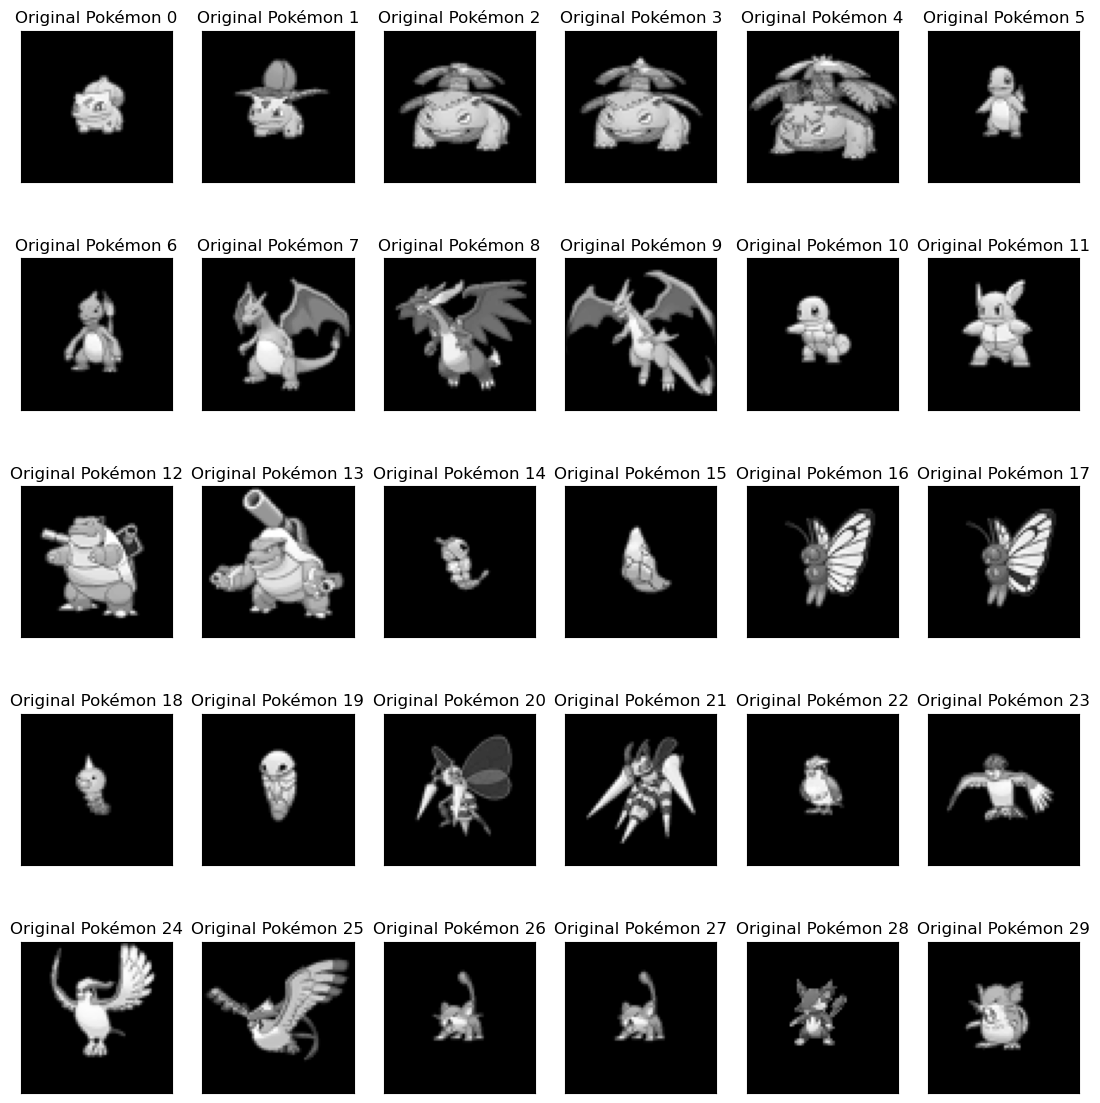

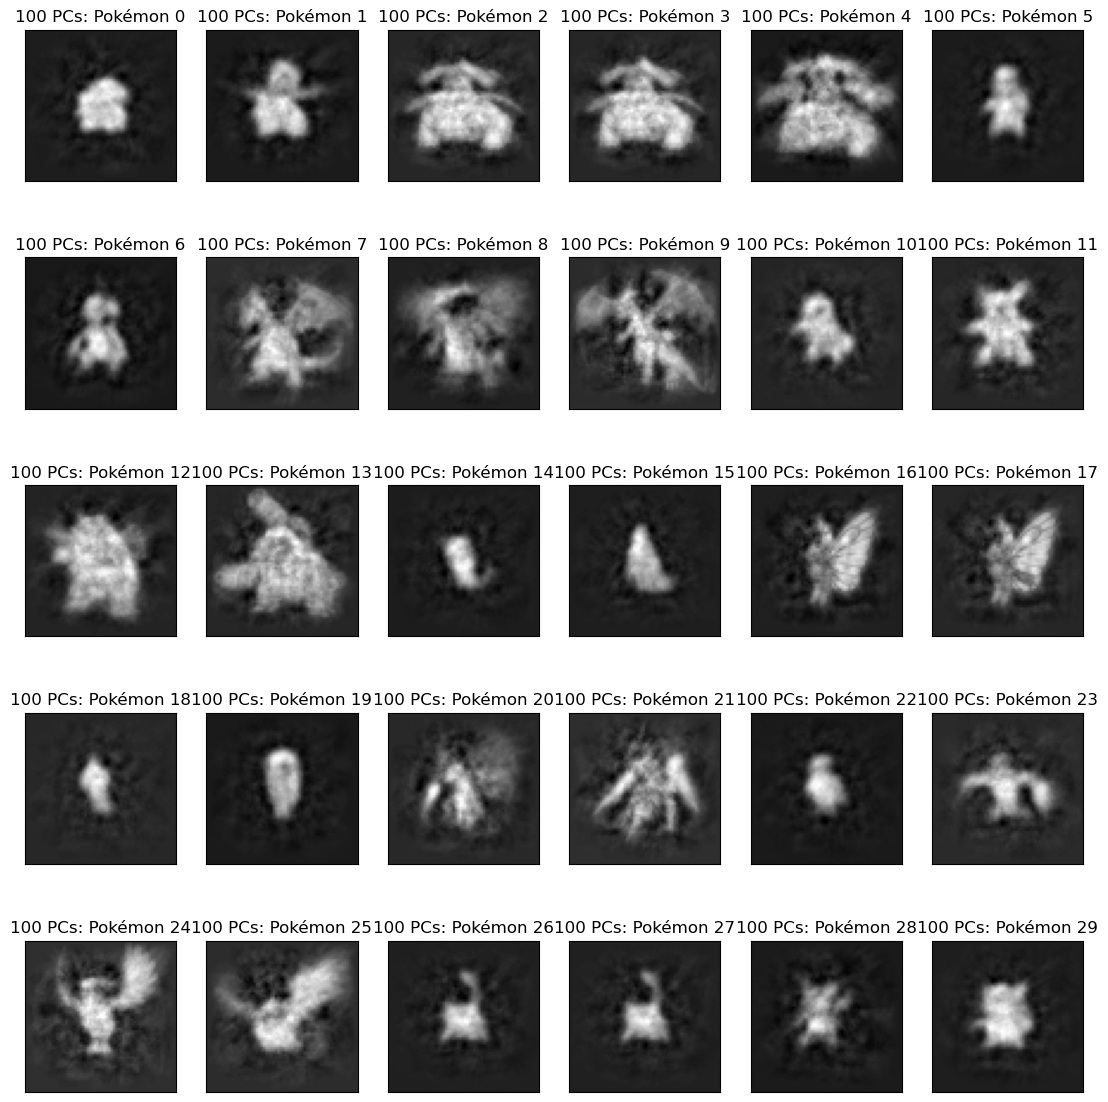

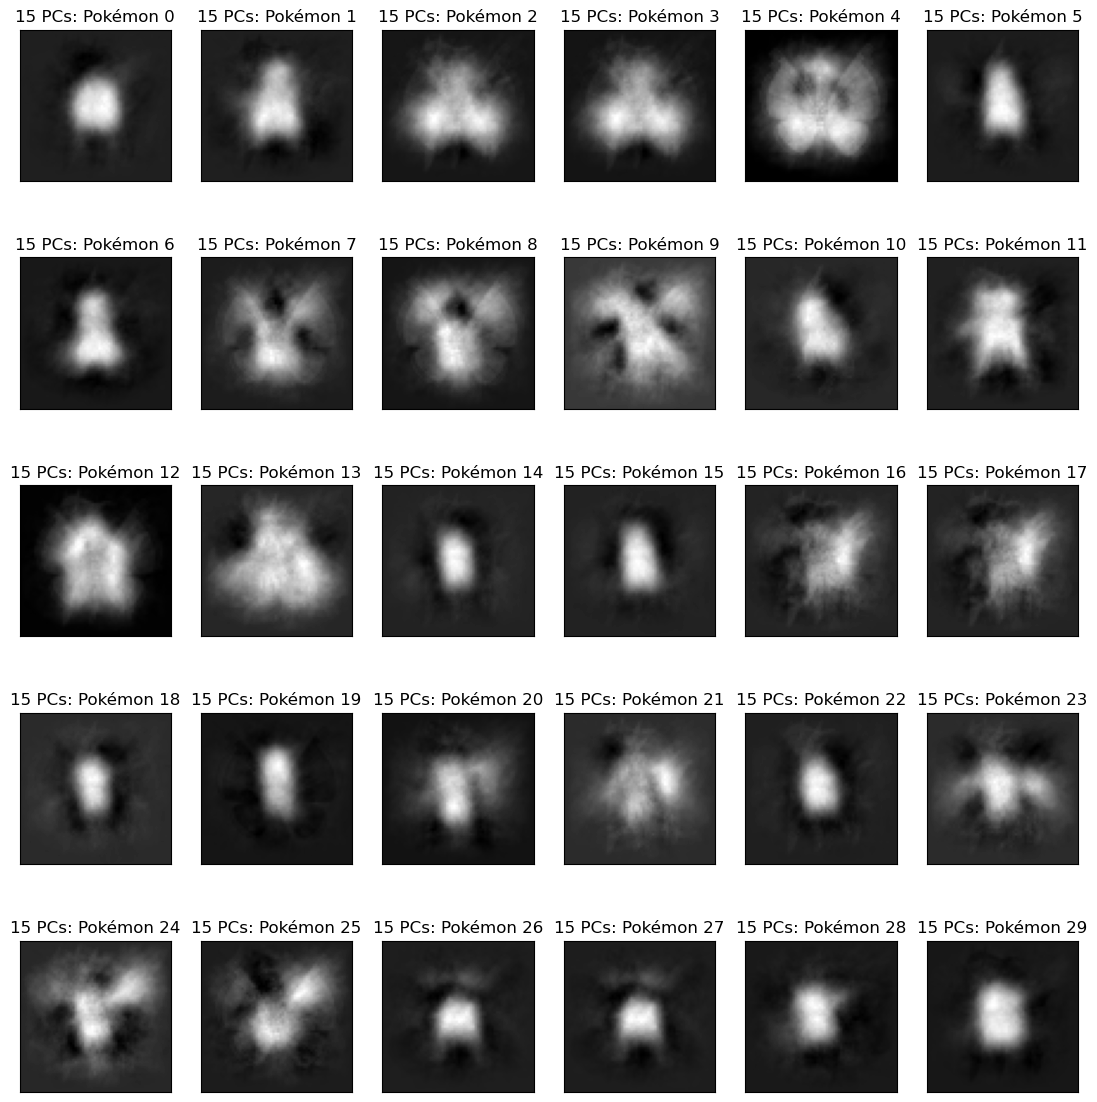

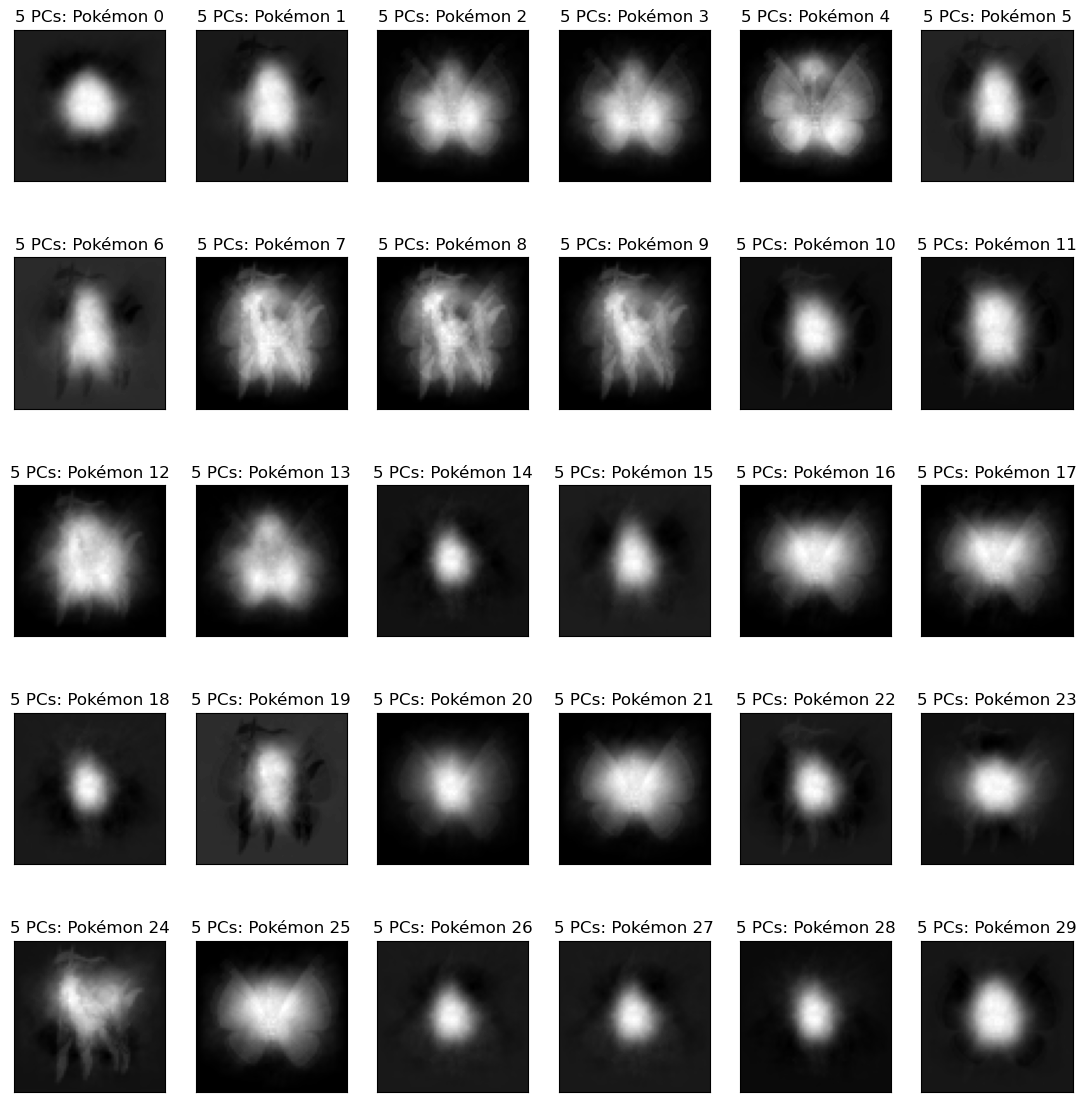

In [6]:
# Calculate the mean of the original images
M = np.mean(images, axis=0)

# First, let's look at some original images
plot_gallery(images, ['Original Pokémon {}'.format(i) for i in range(30)], h, w, 5, 6)

# Reconstruct using all 100 principal components
Z, P, S = svd2pca(U, S, Vt, n_pc=100)
reconstructed_100 = np.dot(Z, P) + M
plot_gallery(reconstructed_100, ['100 PCs: Pokémon {}'.format(i) for i in range(30)], h, w, 5, 6)

# Reconstruct using only 15 principal components
Z, P, S = svd2pca(U, S, Vt, n_pc=15)
reconstructed_15 = np.dot(Z, P) + M
plot_gallery(reconstructed_15, ['15 PCs: Pokémon {}'.format(i) for i in range(30)], h, w, 5, 6)

# Reconstruct using just 5 principal components
Z, P, S = svd2pca(U, S, Vt, n_pc=5)
reconstructed_5 = np.dot(Z, P) + M
plot_gallery(reconstructed_5, ['5 PCs: Pokémon {}'.format(i) for i in range(30)], h, w, 5, 6)

Let's analyze what we're seeing in these reconstructions:

1. **100 Principal Components**: With 100 PCs (about 2.4% of the original 4,096 dimensions), the reconstructed Pokémon are largely recognizable with the basic shapes preserved, but many details are still lost. This suggests that while the general structure of our Pokémon sprites can be captured in a much lower-dimensional space, fine visual details require significantly more dimensions.

2. **15 Principal Components**: With just 15 PCs (0.37% of the original dimensions), we can see that while some key features and overall shapes are preserved, most fine details are lost. 
 
3. **5 Principal Components**: With only 5 PCs (0.12% of the original dimensions), we get much more basic representations. The general silhouettes are still somewhat recognizable, but most details are lost, and Pokémon become difficult to identify. At this extreme level of dimensionality reduction, we're essentially capturing only the most dominant features like overall shape and color distribution.

This progressive loss of detail demonstrates the trade-off in PCA: fewer components means more compression and dimensionality reduction, but at the cost of lost information. For many applications, the key is finding the "sweet spot" - the number of components that provides sufficient compression while preserving the information that matters for your specific task.

## Storage Efficiency of PCA
 
Let's quantify the storage savings achieved through PCA:

- Each Pokémon image: $64 \times 64 = 4,096$ pixels (dimensions)
- Total dataset (n images): $N \times 4,096$ values
 
With $M$ principal components:
1. Principal components matrix: $P = V_M^T \in \mathbb{R}^{M \times D}$ (where $D=4,096$)
2. Projection coefficients: $Z \in \mathbb{R}^{N \times M}$
3. Mean vector: $\mu \in \mathbb{R}^D$
 
Total storage: $M \times D + N \times M + D = D(M + 1) + NM$ values
  
### Compression Ratio
 
For our dataset with $n=1168$ Pokémon images:
- Original: $1168 \times 4,096 = 4,784,128$ values
- With 100 PCs: $4,096 \times 101 + 1168 \times 100 = 530,496$ values (89% reduction)
- With 15 PCs: $4,096 \times 16 + 1168 \times 15 = 82,976$ values (98% reduction)
- With 5 PCs: $4,096 \times 6 + 1168 \times 5 = 30,016$ values (99% reduction)
  
This is significantly more efficient than storing the raw pixel data, especially when $M \ll D$ and we have many images ($N$ is large).


## Applying PCA to Astronomical Data: Galaxy Images

Now that we've explored PCA with Pokémon sprites, let's turn to a more astronomical application: analyzing galaxy images. Galaxy morphology—the structure and appearance of galaxies—is a rich field of study in astronomy, and dimensionality reduction techniques like PCA can help us identify the key features that characterize different types of galaxies.

### The Galaxy Dataset

For this part of the tutorial, we'll use a dataset of galaxy images from the Hyper Suprime-Cam (HSC). Each image has been scaled to 64×64 pixels for consistency with our Pokémon example. Let's load the dataset and take a look at some example images:

Shape of the galaxy images: (2101, 4096)
Number of galaxy images: 2101
Dimensions per image: 4096


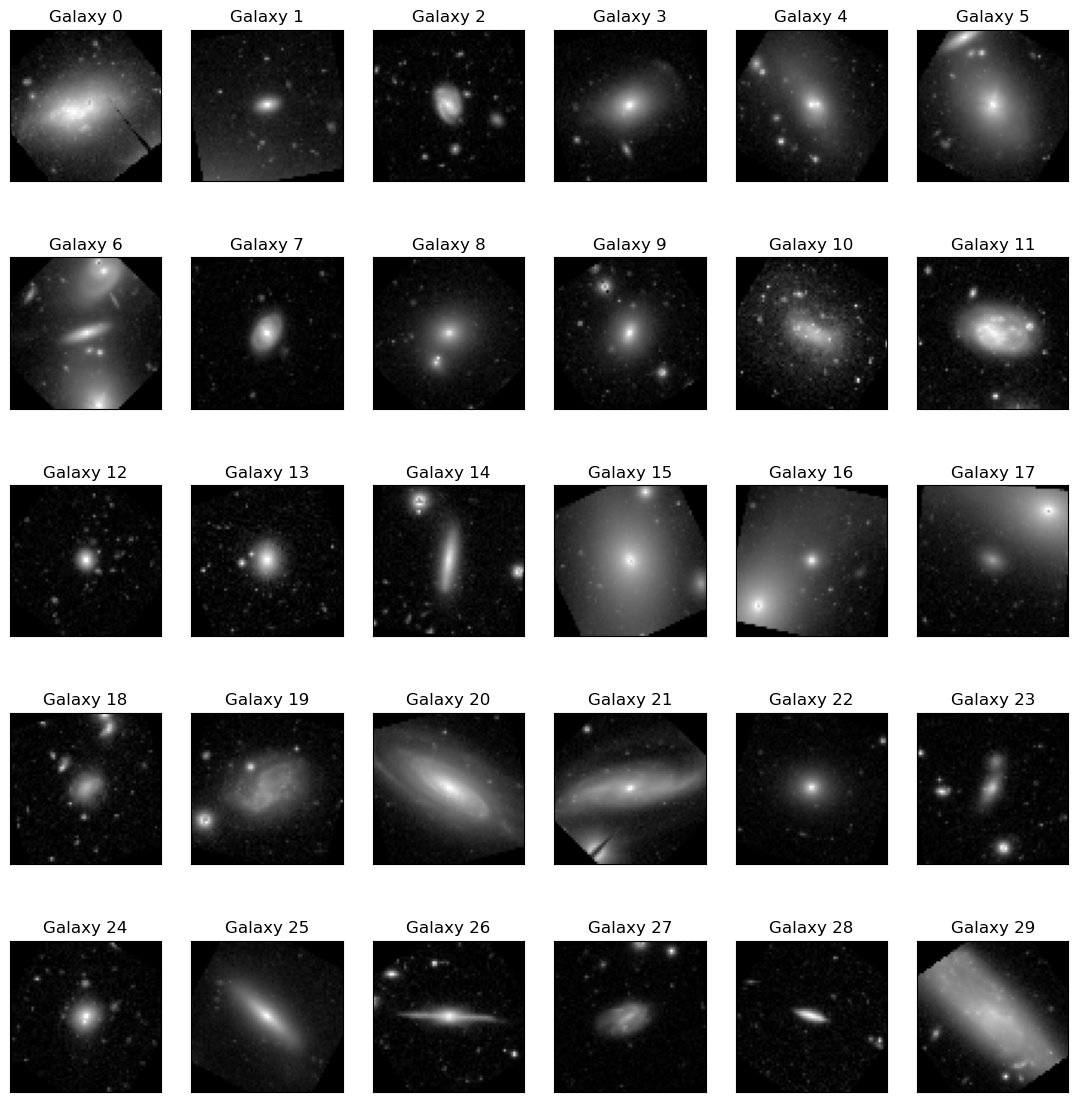

In [7]:
# Load the galaxy image dataset
galaxy_images = np.load('dataset_images_galaxy.npy')

# Check the shape of the loaded data
print("Shape of the galaxy images:", galaxy_images.shape)
print(f"Number of galaxy images: {galaxy_images.shape[0]}")
print(f"Dimensions per image: {galaxy_images.shape[1]}")

# Display a sample of galaxy images
plot_gallery(galaxy_images, [f"Galaxy {i}" for i in range(30)], 64, 64, 5, 6)

### "Eigen-galaxies": Principal Components of Galaxy Images

Just as we computed "Eigen-Pokémon" earlier, we can now compute "Eigen-galaxies" - the principal components of our galaxy image dataset. These components will reveal the dominant patterns of variation across different galaxy images.

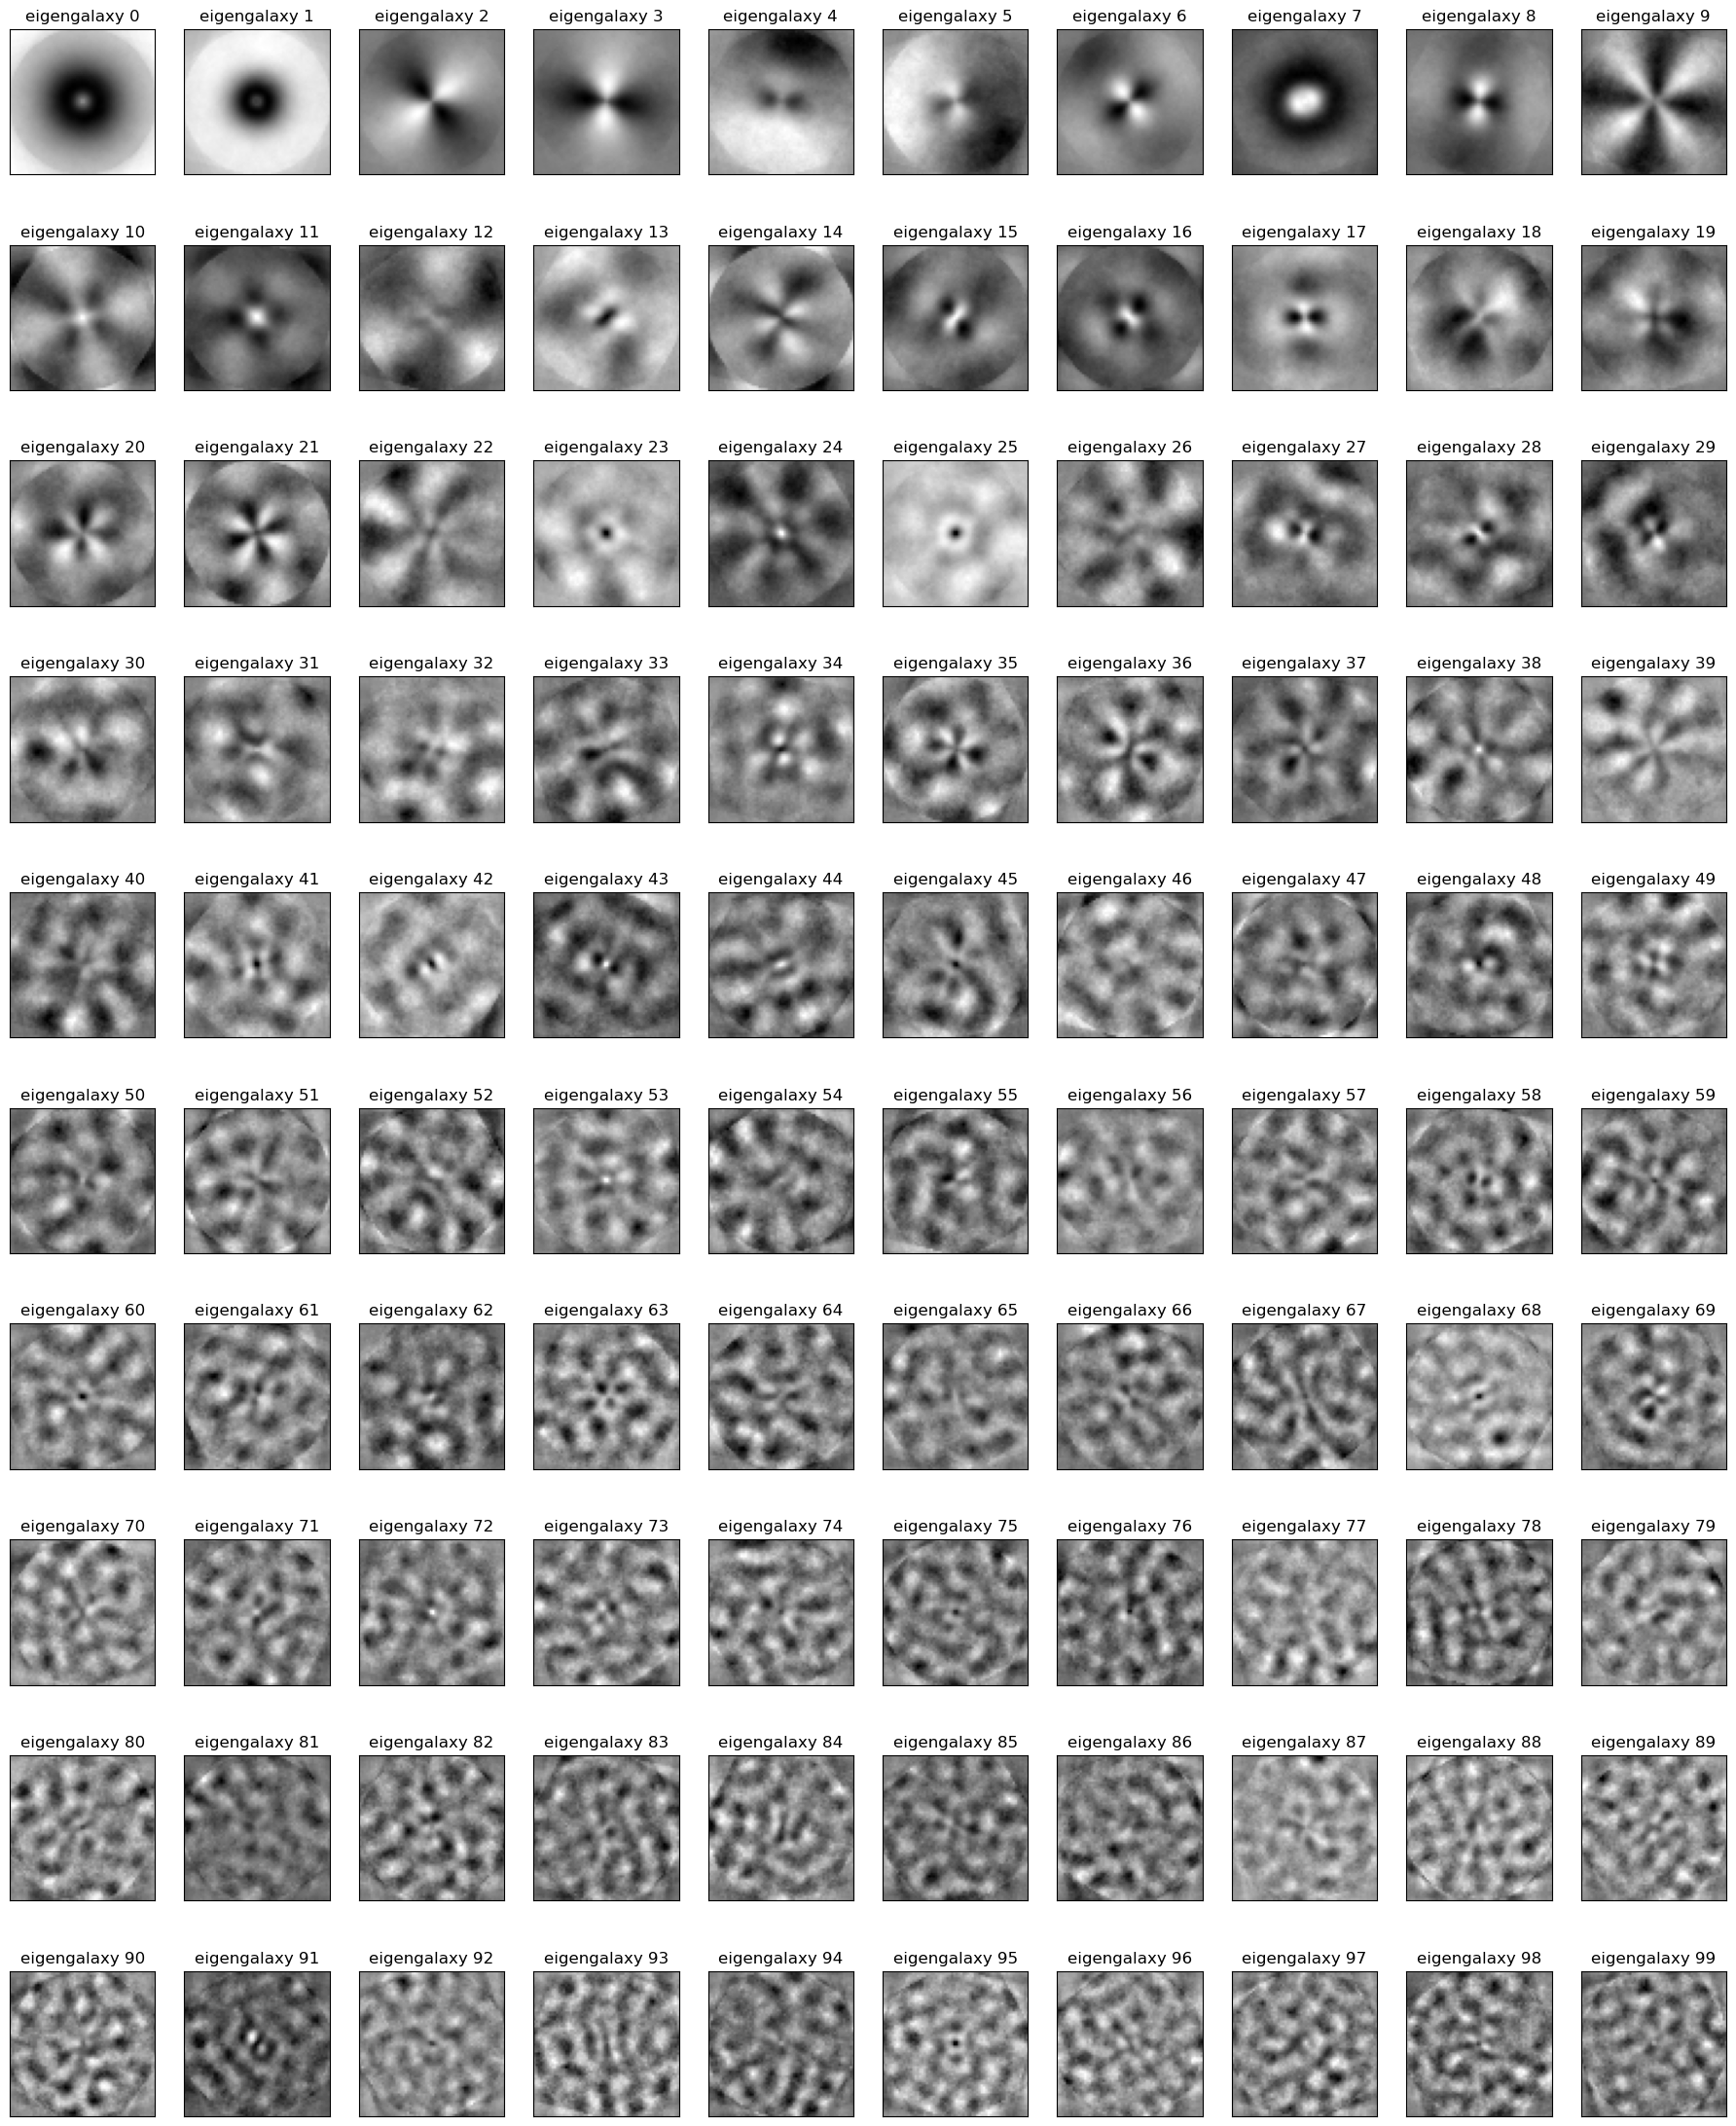

In [8]:
# Perform PCA on the galaxy images
galaxy_Z, galaxy_P, galaxy_U, galaxy_S, galaxy_Vt = pca(galaxy_images, n_pc=100)

# Reshape the principal components to visualize them as images
eigengalaxies = galaxy_P.reshape((100, 64, 64))

# Generate titles for the gallery
eigengalaxy_titles = [f"eigengalaxy {i}" for i in range(100)]

# Visualize the first 100 principal components
plot_gallery(eigengalaxies, eigengalaxy_titles, 64, 64, 10, 10)

Take a moment to examine these galaxy principal components:

1. **First component (eigengalaxy 0-1)**: This typically captures the most common feature across all galaxy images - often related to the overall brightness distribution and central bulge.

2. **Early components (eigengalaxies 2-10)**: These represent major variations in galaxy structure, such as presence of spiral arms, or orientation.

3. **Middle components (eigengalaxies 11-30)**: As we move further, the components begin to capture more specific features like asymmetries.

4. **Later components (eigengalaxies 31+)**: These represent increasingly fine details and eventually noise patterns in the images.

From an astronomical perspective, these principal components are particularly interesting because they can potentially separate different galaxy types in an unsupervised way. For example, the components related to disk features might help distinguish spiral galaxies from elliptical galaxies.

Let's examine how much variance each component explains in our galaxy dataset:

In [ ]:
# Calculate eigenvalues for galaxy images
galaxy_eigenvalues = (galaxy_S**2) / galaxy_images.shape[0]

# Calculate cumulative explained variance
galaxy_cumulative_variance = np.cumsum(galaxy_eigenvalues) / np.sum(galaxy_eigenvalues)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(galaxy_cumulative_variance)), galaxy_cumulative_variance * 100, color='#2196F3', linewidth=2)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance (%)', fontsize=14)
plt.title('Cumulative Variance Explained (Galaxy Images)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.axhline(y=90, color='#FF9800', linestyle='--', linewidth=1.5, label='90% Explained Variance')
plt.legend()
plt.show()

# Print the number of components needed for 90% explained variance
galaxy_n_components_90 = np.where(galaxy_cumulative_variance >= 0.9)[0][0] + 1
print(f"Number of components needed to explain 90% of variance: {galaxy_n_components_90}")
print(f"This represents {galaxy_n_components_90/len(galaxy_eigenvalues):.2%} of the original dimensions")

Looking at the cumulative variance plot, we can observe that galaxy images show a much steeper increase in explained variance compared to our earlier Pokemon analysis. This is a common characteristic in astrophysics image data - galaxy images tend to be structurally simpler with finite shapes and smoother intensity distributions.
 
This steeper curve means we can effectively represent galaxy images with fewer principal components (eigengalaxies). In fact, we only need about 150 components to capture 90% of the variance, which is remarkably efficient considering the original dimensionality of the data.
 
This property is why dimensionality reduction techniques like PCA are particularly effective in astrophysics - complex astronomical objects can often be cleanly captured with a relatively finite representation using eigenvectors, making them ideal for compression, denoising, and feature extraction tasks.


### Why Satellite Galaxies Are Filtered Out

An interesting observation in our analysis is that the principal components primarily focus on the main galaxy in each image, mostly ignoring smaller satellite galaxies that might be present. This is not a limitation but rather a feature of PCA that makes it useful for denoising astronomical images.
 
PCA works by identifying patterns of pixel values that co-vary across the dataset. The main galaxy in each image contributes significantly to this covariance because of several factors. Due to its size and brightness, the main galaxy occupies more pixels and has higher intensity values compared to satellite galaxies. Additionally, the main galaxy appears consistently in every image, while satellite galaxies appear in different positions or are absent in some images. PCA naturally prioritizes features that explain the most variance, and since satellite galaxies contribute less to the overall variance due to their smaller size and inconsistent presence, they are typically captured in later components that we might not retain when performing dimensionality reduction.

This property makes PCA an effective tool for denoising astronomical images: By keeping only the top principal components, we can filter out random noise and isolate the consistent signal (the main galaxy); in some astronomical applications, smaller background galaxies might be considered noise if the focus is on studying the properties of the main galaxy; and imaging artifacts that don't consistently appear across the dataset are relegated to later principal components and can be eliminated through dimensionality reduction.

Let's see this denoising effect in action by reconstructing galaxy images with different numbers of principal components:

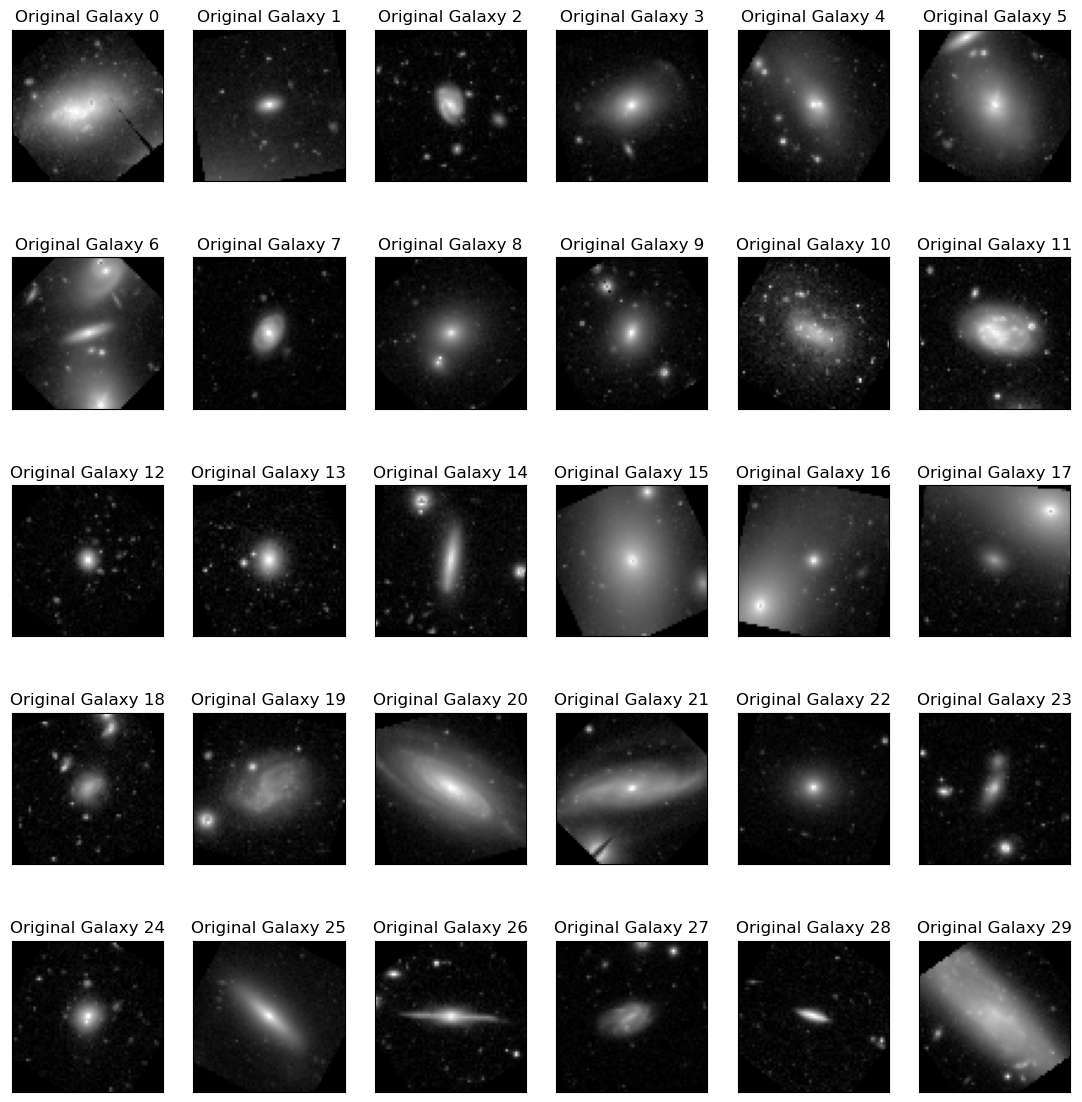

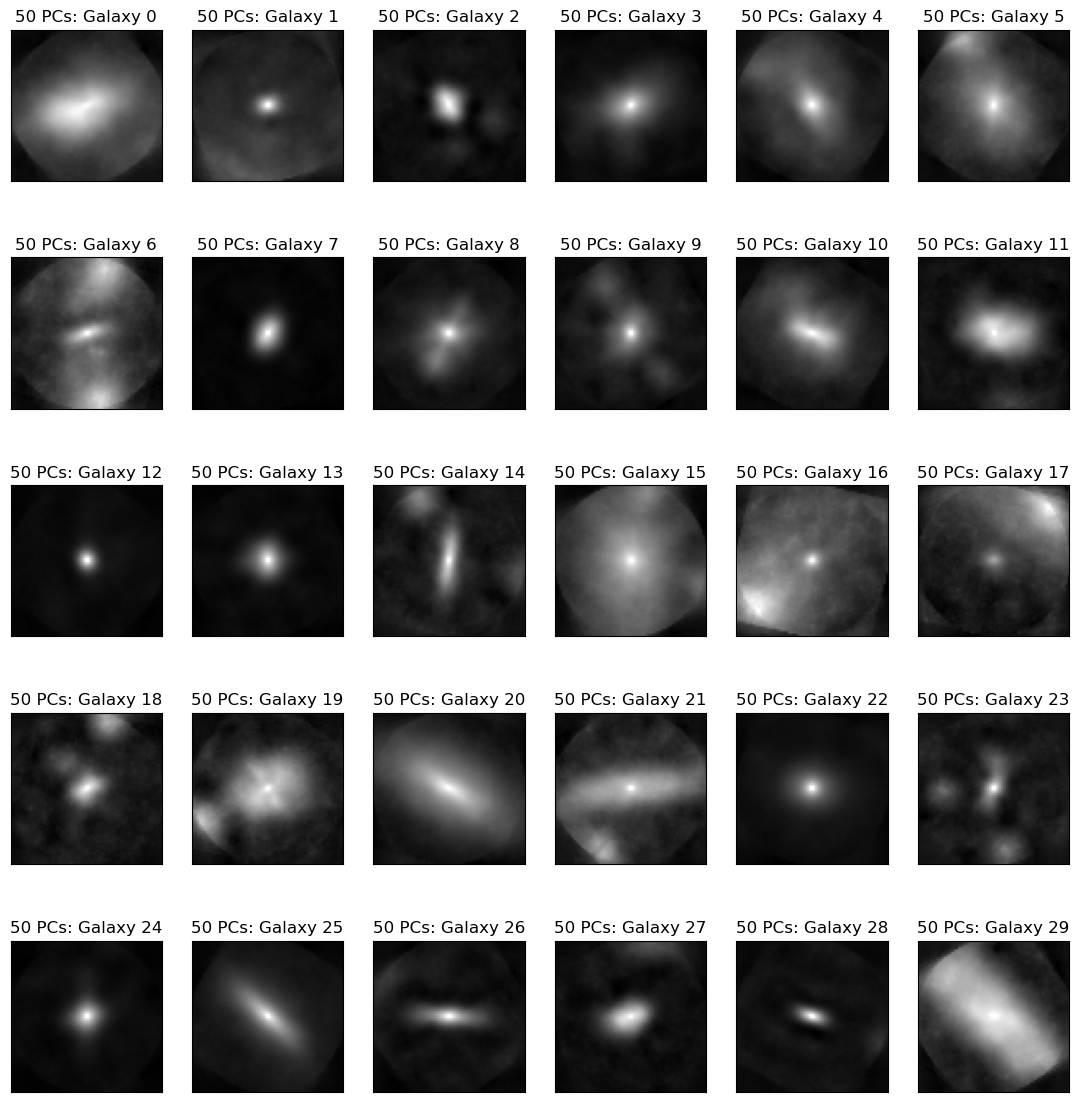

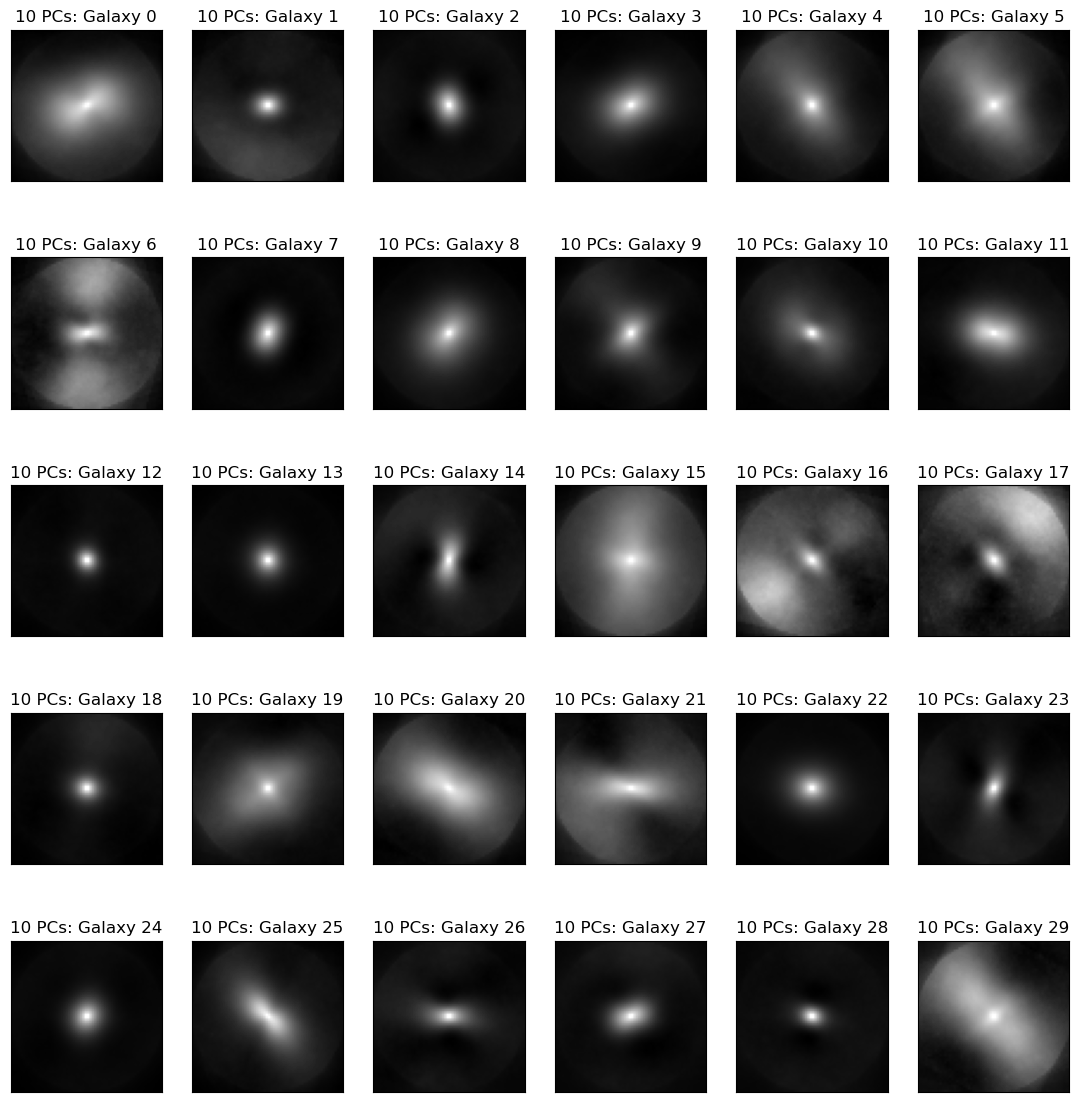

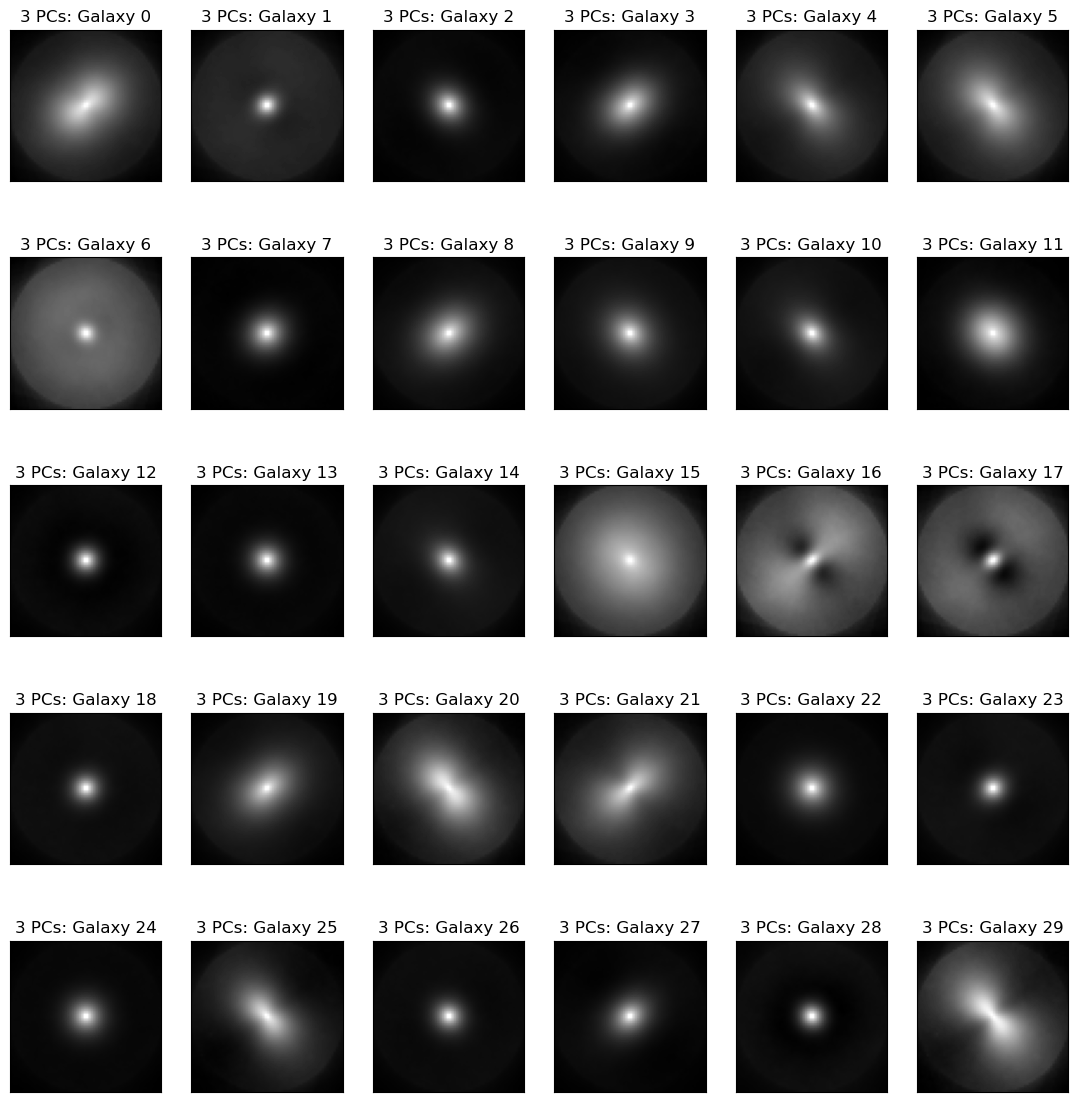

In [9]:
# Calculate the mean of the original galaxy images
galaxy_M = np.mean(galaxy_images, axis=0)

# Visualize original galaxy images
plot_gallery(galaxy_images, ['Original Galaxy {}'.format(i) for i in range(30)], 64, 64, 5, 6)

# Reconstruct using 50 principal components
galaxy_Z, galaxy_P, galaxy_S = svd2pca(galaxy_U, galaxy_S, galaxy_Vt, n_pc=50)
galaxy_reconstructed_50 = np.dot(galaxy_Z, galaxy_P) + galaxy_M
plot_gallery(galaxy_reconstructed_50, ['50 PCs: Galaxy {}'.format(i) for i in range(30)], 64, 64, 5, 6)

# Reconstruct using only 10 principal components
galaxy_Z, galaxy_P, galaxy_S = svd2pca(galaxy_U, galaxy_S, galaxy_Vt, n_pc=10)
galaxy_reconstructed_10 = np.dot(galaxy_Z, galaxy_P) + galaxy_M
plot_gallery(galaxy_reconstructed_10, ['10 PCs: Galaxy {}'.format(i) for i in range(30)], 64, 64, 5, 6)

# Reconstruct using just 3 principal components
galaxy_Z, galaxy_P, galaxy_S = svd2pca(galaxy_U, galaxy_S, galaxy_Vt, n_pc=3)
galaxy_reconstructed_3 = np.dot(galaxy_Z, galaxy_P) + galaxy_M
plot_gallery(galaxy_reconstructed_3, ['3 PCs: Galaxy {}'.format(i) for i in range(30)], 64, 64, 5, 6)

As we can see from the reconstructions above, the quality of galaxy image reconstruction improves significantly as we increase the number of principal components:
 
- With just 3 PCs, we capture the basic shape and position of the main galaxy, but lose most details and any smaller features.
- With 10 PCs, more structural details emerge, and the brightness distribution becomes more accurate.
- With 50 PCs, the reconstruction preserve more of fine features of the main galaxy.
 
Although the reconstruction is not perfect, it's remarkable how well PCA captures the basic shape and structure of galaxies even with relatively few components. This capability is particularly important in astronomical applications such as weak gravitational lensing studies. In weak lensing, astronomers traditionally use parametric models like Sérsic profiles to characterize galaxy shapes before measuring subtle distortions caused by gravitational fields. PCA provides a more robust, data-driven alternative to these parametric approaches.
 
Since weak lensing analysis primarily requires accurate measurements of the overall galaxy shape and orientation rather than fine details, PCA's ability to capture the fundamental morphology with just a few components makes it particularly valuable. The inherent shape of galaxies is what we're ultimately after in such analyses, and PCA efficiently extracts this information while naturally filtering out noise and irregular features.
 
However, it's important to note that, similar to what we observed with Pokémon images, linear decomposition methods like PCA have inherent limitations when applied to complex image data. The reconstructions, even with many components, still lose some of the fine details and subtle features present in the original images. Additionally, the orthogonality constraint of principal components, while mathematically elegant, can make individual components difficult to interpret in a physically meaningful way. This is because real-world features in images (like galaxy arms or specific structures) may not naturally align with orthogonal directions in the data space, resulting in components that represent mixtures of actual physical features rather than isolated, interpretable elements.
 
For more sophisticated image reconstruction, more complex models beyond PCA would be needed. Neural network-based autoencoders, for example, can learn non-linear encodings that often produce much better reconstructions with fewer parameters. These models can capture more complex patterns and relationships in the data that PCA cannot represent. However, exploring such advanced techniques is beyond the scope of this lecture.


## Conclusion:

Throughout this tutorial, we've explored Principal Component Analysis through two diverse applications: Pokémon sprite images and astronomical galaxy images. This journey has revealed both the power and limitations of PCA as a dimensionality reduction technique.

### What We've Learned

1. **Mathematical Foundation**: We've seen how PCA transforms our data into a new coordinate system where axes are ordered by variance, allowing us to reduce dimensions while preserving the most important information.

2. **Implementation**: We've implemented PCA from scratch using SVD, giving us insight into the algorithm's inner workings and flexibility in our analysis.

3. **Visual Interpretation**: By visualizing principal components as "Eigen-Pokémon" and "Eigen-galaxies," we've gained intuition about what patterns PCA identifies in different types of image data.

4. **Reconstruction Quality**: We've observed how reconstruction quality degrades as we reduce dimensions.

5. **Denoising Properties**: We've discovered PCA's natural ability to separate dominant signals from noise, making it useful for cleaning astronomical images.

### Limitations and Considerations

While PCA is powerful, it's important to recognize its limitations:

1. **Linearity**: PCA can only identify linear relationships in the data. For highly non-linear structures, other techniques like autoencoders might be more appropriate.

2. **Variance Focus**: PCA prioritizes variance, which might not always align with what's most important for a specific task. Features with high variance aren't necessarily the most discriminative.

3. **Interpretability Challenges**: While early components are often interpretable, understanding what later components represent can be difficult, especially in complex datasets.


### Future Directions

For those interested in exploring beyond PCA, consider:

- **Kernel PCA**: Extends PCA to handle non-linear relationships
- **t-SNE and UMAP**: Non-linear techniques that better preserve local structure
- **Autoencoders**: Neural network-based approaches that can capture complex, non-linear patterns

By understanding both the strengths and limitations of PCA, you're now better equipped to apply dimensionality reduction techniques to your own data analysis challenges, whether in astronomy or other fields.